In [1]:
from typing import Final

import numpy as np

In [2]:
RANDOM_SEED:  Final[int]    = 42
TEST_SIZE:    Final[float]  = 0.2

np.random.seed(RANDOM_SEED)

In [3]:
def entropy(y):
    """
    Berechnet die Entropie eines gegebenen Datensatzes y.

    Args:
        y (array-like): Ein Array oder eine Liste von Zielwerten (Labels)

    Returns:
        float: Die Entropie des Datensatzes y.

    Beispiel:
        entropy([1, 1, 0, 0]) -> 1.0
    """
    _, counts = np.unique(y, return_counts=True)
    prob = counts / len(y)

    # y = H(V) = -Σ P(Bj) * log2(P(Bj))
    return -np.sum(prob * np.log2(prob))


def information_gain(X, y, feature_index):
    """
    Berechnet den Informationsgewinn für ein bestimmtes Feature im Datensatz.

    Args:
        X (array-like): Das Array der Eingabefeatures
        y (array-like): Die Labels, die mit X verknüpft sind.
        feature_index (int): Der Index des Features, für das der Informationsgewinn berechnet wird.

    Returns:
        float: Der Informationsgewinn für das angegebene Feature.

    Beispiel:
        information_gain(X, y, 0) -> 0.5
    """
    parent_entropy = entropy(y)
    unique_values = np.unique(X[:, feature_index])

    weighted_entropy = 0
    for value in unique_values:
        subset_y = y[X[:, feature_index] == value]

        # P(Ai | Bj) * H(V | Bj)
        weighted_entropy += (len(subset_y) / len(y)) * entropy(subset_y)

    # IG(V, W) = H(V) - H(V|W)
    return parent_entropy - weighted_entropy


def best_split(X, y):
    """
    Bestimmt das beste Feature für den Split, basierend auf dem maximalen Informationsgewinn.

    Args:
        X (array-like): Das Array der Eingabefeatures.
        y (array-like): Das Ziel-Array (Labels), das mit X verknüpft ist.

    Returns:
        tuple: Ein Tupel, das den Index des besten Features und den maximalen Informationsgewinn enthält.

    Beispiel:
        best_split(X, y) -> (0, 0.25)
    """
    best_feature_index = None
    best_info_gain     = -1

    for feature_index in range(X.shape[1]):
        info_gain = information_gain(X, y, feature_index)
        if info_gain > best_info_gain:
            best_info_gain     = info_gain
            best_feature_index = feature_index

    return best_feature_index, best_info_gain

In [ ]:
class MyDecisionTree:
    """
    Ein einfacher Entscheidungsbaum-Algorithmus für binäre Klassifikation.

    Args:
        max_depth (int): Die maximale Tiefe des Entscheidungsbaums. Wenn nicht angegeben, wird der Baum so tief wie nötig gebaut.

    Methoden:
        - fit(X, y): Trainiert den Entscheidungsbaum mit den Eingabedaten X und den Zielwerten y.
        - predict(X): Gibt die vorhergesagten Labels für die Eingabedaten X zurück.

    Beispiel:
        tree = MyDecisionTree(max_depth=3)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
    
    Referenzen:
        - Vorlesungsfolien: ML_VL_9_Entscheidungsbaeume.pdf 
        - https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/
        - https://medium.com/@omidsaghatchian/decision-tree-implementation-from-scratch-visualization-5eb0bbf427c2
        - https://www.kaggle.com/code/fareselmenshawii/decision-tree-from-scratch
    """
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Wenn alle Beispiele in der gleichen Klasse sind, ist dies ein Blatt
        if len(np.unique(y)) == 1:
            return {"label": np.unique(y)[0]}

        # Wenn keine weiteren Splits möglich sind oder die max. Tiefe erreicht ist, ist dies ein Blatt
        if len(X) == 0 or (self.max_depth and depth >= self.max_depth):
            return {"label": np.bincount(y).argmax()}

        feature_index, info_gain = best_split(X, y)

        # Wenn der Information Gain 0 ist, ist dies auch ein Blatt
        if info_gain == 0:
            return {"label": np.bincount(y).argmax()}

        unique_values = np.unique(X[:, feature_index])
        tree = {"feature_index": feature_index, "branches": {}}

        for value in unique_values:
            subset_X = X[X[:, feature_index] == value]
            subset_y = y[X[:, feature_index] == value]
            tree["branches"][value] = self._build_tree(subset_X, subset_y, depth + 1)

        return tree

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, tree):
        if "label" in tree:
            return tree["label"]

        feature_value = x[tree["feature_index"]]
        branch = tree["branches"].get(feature_value)

        if branch is None:
            return None

        return self._predict_one(x, branch)

In [5]:
def my_train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(X)
    test_size = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)

    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


def my_accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(np.equal(y_true, y_pred))
    total_predictions   = len(y_true)

    return correct_predictions / total_predictions


In [6]:
from sklearn import datasets

X,y =  datasets.load_iris(return_X_y=True, as_frame=True)
X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [7]:
tree = MyDecisionTree()
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
accuracy = my_accuracy_score(y_test, predictions)
print(f"Genauigkeit: {accuracy:.2f}")

Genauigkeit: 0.70


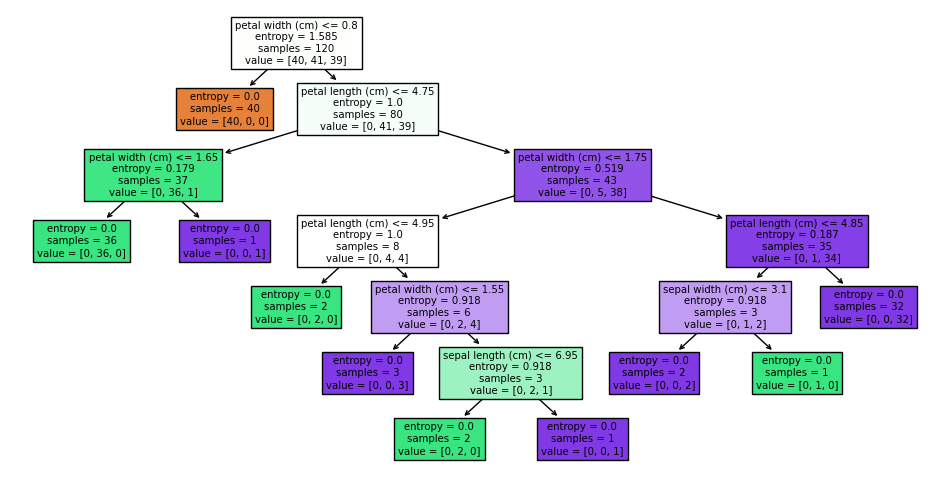

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_sklearn = DecisionTreeClassifier(criterion="entropy")
tree_sklearn.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(tree_sklearn, filled=True, feature_names=datasets.load_iris().feature_names)
plt.show()